# Usagi vs Fuzzy vs Medcat

In this notebook, we are try to analyse the performance of concept mapping strategies namely Usagi, Fuzzy, and Medcat for five different concept categories. The concapt categories that we are interested in and their corresponding target standard vocabulary is given below;

1. `mimiciv_drug_ndc` - RxNorm
2. `mimiciv_micro_organism` - SNOMED
3. `mimiciv_meas_lab_loinc` - LOINC
4. `mimiciv_proc_datetimeevents` - SNOMED
5. `mimiciv_drug_route` - SNOMED

## Initialise variables and function

### Define the variables

In [4]:
dataDir = 'data'
totalCounts = {}
textSimilarityScores = {}
semanticSimilarityScores = {}

### Define a function to calculate `Text Similarity` (Using Token Sort Ratio)

In [5]:
from fuzzywuzzy import fuzz

def calculateTextSimilarityScore(conceptName, mappedConceptName):
    if mappedConceptName:
        mappedConceptName = str(mappedConceptName)
        if len(mappedConceptName) > 0:
            return fuzz.token_sort_ratio(conceptName, mappedConceptName)
    return 0

/home/yram0006/phd/chapter_1/workspace/EHRQC/.venv/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Define a function to calculate `Semantic Similarity` (Using Phrase Embeddings)

In [6]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('pritamdeka/S-BioBert-snli-multinli-stsb')

def calculateSemanticSimilarityScore(conceptName, mappedConceptName):
    if mappedConceptName:
        mappedConceptName = str(mappedConceptName)
        if len(mappedConceptName) > 0:
            conceptNameEmbedding = model.encode(conceptName, convert_to_tensor=True)
            mappedConceptNameEmbedding = model.encode(mappedConceptName, convert_to_tensor=True)
            similarityScore = util.pytorch_cos_sim(conceptNameEmbedding, mappedConceptNameEmbedding)
            return similarityScore
    return 0

/home/yram0006/phd/chapter_1/workspace/EHRQC/.venv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Read the concept to be mapped from the file

In [7]:
import pandas as pd
from pathlib import Path

conceptsDf = pd.read_csv(Path(dataDir, 'concept_names.txt'), sep='\t', dtype=str)
conceptsDf

,concept_name,concept_code,source_concept_id,source_vocabulary_id,source_domain_id,source_concept_class_id,target_concept_id,relationship_id,reverese_relationship_id,concept_name_con,domain_id,vocab_id,concept_class_id,standard
0,Emergency Department,Emergency Department,2000001901,mimiciv_cs_place_of_service,Visit,Visit,8870,Maps to,Mapped from,Emergency Room - Hospital,Visit,CMS Place of Service,Visit,S
1,Medicine,Medicine,2000001902,mimiciv_cs_place_of_service,Visit,Visit,38004515,Maps to,Mapped from,Hospital,Visit,Medicare Specialty,Visit,S
2,Emergency Department Observation,Emergency Department Observation,2000001903,mimiciv_cs_place_of_service,Visit,Visit,8870,Maps to,Mapped from,Emergency Room - Hospital,Visit,CMS Place of Service,Visit,S
3,Nursery - Well Babies,Nursery - Well Babies,2000001904,mimiciv_cs_place_of_service,Visit,Visit,4160140,Maps to,Mapped from,Newborn nursery unit,Observation,SNOMED,Location,S
4,Medicine/Cardiology,Medicine/Cardiology,2000001905,mimiciv_cs_place_of_service,Visit,Visit,581383,Maps to,Mapped from,Inpatient Cardiac Care Facility,Visit,CMS Place of Service,Visit,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3837,NMED,NMED,2000001864,mimiciv_vis_service,Visit,Visit,4150070,Maps to,Mapped from,Neurology department,Observation,SNOMED,Location,S
3838,VSURG,VSURG,2000001865,mimiciv_vis_service,Visit,Visit,4150086,Maps to,Mapped from,Vascular surgery department,Observation,SNOMED,Location,S
3839,PSURG,PSURG,2000001866,mimiciv_vis_service,Visit,Visit,4150085,Maps to,Mapped from,Plastic surgery department,Observation,SNOMED,Location,S
3840,TSURG,TSURG,2000001867,mimiciv_vis_service,Observation,Location,4148989,Maps to,Mapped from,Thoracic surgery department,Observation,SNOMED,Location,S


### Read the Usagi file

This file contains all the concepts mappings from Usagi. The vocabulary used by Usagi is obtained from Athena download version (v5).

In [8]:
import pandas as pd
from pathlib import Path

usagiDf = pd.read_csv(Path(dataDir, 'mapped_all_athena_usagi.csv'), dtype=str)
usagiDf

,sourceCode,sourceName,sourceFrequency,sourceAutoAssignedConceptIds,ADD_INFO:source_concept_id,matchScore,mappingStatus,targetConceptId,targetConceptName,targetVocabularyId,targetDomainId,targetStandardConcept,targetChildCount,targetParentCount,targetConceptClassId,targetConceptCode,targetValidStartDate,targetValidEndDate,targetInvalidReason
0,70012,BLOOD CULTURE,-1,NaN,2000025510,1.0,UNCHECKED,37392838,Blood culture,SNOMED,Measurement,S,0,1,Observable Entity,1009211000000104,20160401,20991231,NaN
1,TRAUMATIC INJURY W/O MCC,TRAUMATIC INJURY W/O MCC,-1,NaN,2000020869,1.0,UNCHECKED,38001589,Traumatic injury w/o MCC,DRG,Observation,S,0,1,MS-DRG,914,20071001,20991231,NaN
2,70013,FLUID RECEIVED IN BLOOD CULTURE BOTTLES,-1,NaN,2000025511,0.6285208463668823,UNCHECKED,35624569,Aerobic blood culture bottle,SNOMED,Device,S,0,1,Physical Object,767385003,20180731,20991231,NaN
3,Pulmicort Turbuhaler 200 mcg,Budesonide 0.2 MG/ACTUAT [Pulmicort Turbuhaler],-1,NaN,2000011191,1.0,UNCHECKED,42958532,Budesonide 0.2 MG/ACTUAT [Pulmicort Turbuhaler],RxNorm Extension,Drug,S,5,0,Branded Drug Comp,OMOP4685041,20180821,20991231,NaN
4,OTHER MUSCULOSKELETAL SYS & CONNECTIVE TISSUE ...,OTHER MUSCULOSKELETAL SYS & CONNECTIVE TISSUE ...,-1,NaN,2000020628,1.0,UNCHECKED,38001340,Other musculoskeletal sys & connective tissue ...,DRG,Observation,S,0,1,MS-DRG,566,20071001,20991231,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3837,Xenaderm ea,Castor Oil / Peruvian balsam / TRYPSIN Topical...,-1,NaN,2000010231,1.0,UNCHECKED,40125480,castor oil / Peruvian balsam / trypsin Topical...,RxNorm,Drug,S,1,8,Branded Drug Form,581756,20051113,20991231,NaN
3838,Isradipine 15mg,Isradipine,-1,NaN,2000010232,1.0,UNCHECKED,1326012,isradipine,RxNorm,Drug,S,34,1,Ingredient,33910,19700101,20991231,NaN
3839,Zestoretic Zestoretic,Hydrochlorothiazide / Lisinopril Oral Tablet [...,-1,NaN,2000010233,1.0,UNCHECKED,40155308,hydrochlorothiazide / lisinopril Oral Tablet [...,RxNorm,Drug,S,3,11,Branded Drug Form,823970,20081130,20991231,NaN
3840,Symbicort 160/4.5,60 ACTUAT Budesonide 0.16 MG/ACTUAT / formoter...,-1,NaN,2000010234,1.0,UNCHECKED,42708517,60 ACTUAT budesonide 0.16 MG/ACTUAT / formoter...,RxNorm,Drug,S,0,9,Quant Branded Drug,1246317,20120507,20991231,NaN


### Define a function to create a combined dataframe

In [9]:
import ast
import pandas as pd
from pathlib import Path


def createCombinedDataframe(conceptType:str, vocabularyType:str, conceptsDf:pd.DataFrame = conceptsDf, usagiDf:pd.DataFrame=usagiDf):

    fuzzyDf = pd.read_csv(Path(dataDir, 'mapped_' + conceptType + '_' + vocabularyType + '_fuzzy.csv'), dtype=str)

    medcatDf = pd.read_csv(Path(dataDir, 'mapped_' + conceptType + '_' + vocabularyType + '_medcat.csv'), dtype=str)

    conceptsDf = conceptsDf[conceptsDf.source_vocabulary_id == conceptType]

    usagiDf = usagiDf[usagiDf['ADD_INFO:source_concept_id'].isin(conceptsDf.source_concept_id)]

    mergedDf = conceptsDf\
        .merge(usagiDf, left_on='source_concept_id', right_on='ADD_INFO:source_concept_id', how='inner')\
            .merge(medcatDf.add_suffix('_medcat'), left_on='source_concept_id', right_on='source_concept_id_medcat', how='inner')\
                .merge(fuzzyDf.add_suffix('_fuzzy'), left_on='source_concept_id', right_on='source_concept_id_fuzzy', how='inner')

    mergedDf['matching_pretty_name_medcat'] = mergedDf['matching_concept_name_medcat'].apply(ast.literal_eval).apply(lambda x: x[0])
    mergedDf['matching_source_value_medcat'] = mergedDf['matching_concept_name_medcat'].apply(ast.literal_eval).apply(lambda x: x[1])

    mergedDf.to_csv(Path(dataDir, 'mapped_' + conceptType + '_' + vocabularyType + '_all.csv'), index=False)

    return mergedDf

### Define a function to draw upset plot of all four mapping strategies (three automatic and the manual mapping)

In [10]:
from upsetplot import from_contents, UpSet


def drawUpsetPlot(mergedDf):

    mappedIdsManual = set(mergedDf['target_concept_id'])
    mappedIdsFuzzy = set(mergedDf['matching_concept_id_fuzzy'])
    mappedIdsUsagi = set(mergedDf['targetConceptId'])
    mappedIdsMedcat = set(mergedDf['matching_concept_id_medcat'])

    upsetPlotData = from_contents({'manual': mappedIdsManual, 'fuzzy': mappedIdsFuzzy, 'usagi': mappedIdsUsagi, 'medcat': mappedIdsMedcat})

    UpSet(upsetPlotData, show_counts=True, facecolor="darkblue").plot()

### Define a function to display overall counts

In [11]:
from matplotlib import pyplot as plt


def drawOverallCounts(mergedDf, conceptType:str):

    total_count_manual = mergedDf[mergedDf['concept_name_con'].notna()]['concept_name'].count()
    total_count_fuzzy = mergedDf[mergedDf['matching_concept_name_fuzzy'].notna()]['concept_name'].count()
    total_count_usagi = mergedDf[mergedDf['targetConceptName'].notna()]['concept_name'].count()
    total_count_pretty_name_medcat = mergedDf[mergedDf['matching_pretty_name_medcat'].notna()]['concept_name'].count()
    total_count_source_value_medcat = mergedDf[mergedDf['matching_source_value_medcat'].notna()]['concept_name'].count()

    # plt.figure(figsize=(10, 15))
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(
        x=['Manual', 'Fuzzy', 'Usagi', 'Pretty Name Medcat', 'Source Value Medcat'],
        height=[
            total_count_manual,
            total_count_fuzzy,
            total_count_usagi,
            total_count_pretty_name_medcat,
            total_count_source_value_medcat,
            ],
        )
    ax.set_title('Overall Counts for ' + conceptType + ' Mapping')
    plt.xticks(rotation=75, ha='right')
    plt.show()

    return total_count_manual, total_count_fuzzy, total_count_usagi, total_count_pretty_name_medcat, total_count_source_value_medcat

### Defina a function to calculate text similarity scores

In [12]:
def calculateTextSimilarity(mergedDf):
    mergedDf['text_similarity_score_manual'] = [calculateTextSimilarityScore(row['concept_name'], row['concept_name_con']) for _, row in mergedDf.iterrows()]
    mergedDf['text_similarity_score_fuzzy'] = [calculateTextSimilarityScore(row['concept_name'], row['matching_concept_name_fuzzy']) for _, row in mergedDf.iterrows()]
    mergedDf['text_similarity_score_usagi'] = [calculateTextSimilarityScore(row['concept_name'], row['targetConceptName']) for _, row in mergedDf.iterrows()]
    mergedDf['text_similarity_score_pretty_name_medcat'] = [calculateTextSimilarityScore(row['concept_name'], row['matching_pretty_name_medcat']) for _, row in mergedDf.iterrows()]
    mergedDf['text_similarity_score_source_value_medcat'] = [calculateTextSimilarityScore(row['concept_name'], row['matching_source_value_medcat']) for _, row in mergedDf.iterrows()]
    return mergedDf

### Define a function to display average text similarity scores

In [13]:
from matplotlib import pyplot as plt


def drawAverageTextSimilarityScores(mergedDf, conceptType:str):
    avg_text_similarity_score_manual = mergedDf[mergedDf['concept_name_con'].notna()]['text_similarity_score_manual'].sum()/mergedDf[mergedDf['concept_name_con'].notna()].shape[0]
    avg_text_similarity_score_fuzzy = mergedDf[mergedDf['matching_concept_name_fuzzy'].notna()]['text_similarity_score_fuzzy'].sum()/mergedDf[mergedDf['matching_concept_name_fuzzy'].notna()].shape[0]
    avg_text_similarity_score_usagi = mergedDf[mergedDf['targetConceptName'].notna()]['text_similarity_score_usagi'].sum()/mergedDf[mergedDf['targetConceptName'].notna()].shape[0]
    avg_text_similarity_score_pretty_name_medcat = mergedDf[mergedDf['matching_pretty_name_medcat'].notna()]['text_similarity_score_pretty_name_medcat'].sum()/mergedDf[mergedDf['matching_pretty_name_medcat'].notna()].shape[0]
    avg_text_similarity_score_value_medcat = mergedDf[mergedDf['matching_source_value_medcat'].notna()]['text_similarity_score_source_value_medcat'].sum()/mergedDf[mergedDf['matching_source_value_medcat'].notna()].shape[0]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(
        x=['Manual', 'Fuzzy', 'Usagi', 'Pretty Name Medcat', 'Source Value Medcat'],
        height=[
            avg_text_similarity_score_manual, avg_text_similarity_score_fuzzy, avg_text_similarity_score_usagi, avg_text_similarity_score_pretty_name_medcat, avg_text_similarity_score_value_medcat
            ],
        )
    ax.set_title('Average Text Similarity Scores for ' + conceptType + ' Mapping')
    plt.xticks(rotation=75, ha='right')
    plt.show()

    return avg_text_similarity_score_manual, avg_text_similarity_score_fuzzy, avg_text_similarity_score_usagi, avg_text_similarity_score_pretty_name_medcat, avg_text_similarity_score_value_medcat

### Defina a function to calculate semantic similarity scores

In [14]:
def calculateSemanticSimilarity(mergedDf):
    mergedDf['semantic_similarity_score_manual'] = [calculateSemanticSimilarityScore(row['concept_name'], row['concept_name_con']) for _, row in mergedDf.iterrows()]
    mergedDf['semantic_similarity_score_fuzzy'] = [calculateSemanticSimilarityScore(row['concept_name'], row['matching_concept_name_fuzzy']) for _, row in mergedDf.iterrows()]
    mergedDf['semantic_similarity_score_usagi'] = [calculateSemanticSimilarityScore(row['concept_name'], row['targetConceptName']) for _, row in mergedDf.iterrows()]
    mergedDf['semantic_similarity_score_pretty_name_medcat'] = [calculateSemanticSimilarityScore(row['concept_name'], row['matching_pretty_name_medcat']) for _, row in mergedDf.iterrows()]
    mergedDf['semantic_similarity_score_source_value_medcat'] = [calculateSemanticSimilarityScore(row['concept_name'], row['matching_source_value_medcat']) for _, row in mergedDf.iterrows()]
    return mergedDf

### Define a function to display average semantic similarity scores

In [15]:
from matplotlib import pyplot as plt


def drawAverageSemanticSimilarityScores(mergedDf, conceptType:str):
    avg_semantic_similarity_score_manual = mergedDf[mergedDf['concept_name_con'].notna()]['semantic_similarity_score_manual'].sum()/mergedDf[mergedDf['concept_name_con'].notna()].shape[0]
    avg_semantic_similarity_score_fuzzy = mergedDf[mergedDf['matching_concept_name_fuzzy'].notna()]['semantic_similarity_score_fuzzy'].sum()/mergedDf[mergedDf['matching_concept_name_fuzzy'].notna()].shape[0]
    avg_semantic_similarity_score_usagi = mergedDf[mergedDf['targetConceptName'].notna()]['semantic_similarity_score_usagi'].sum()/mergedDf[mergedDf['targetConceptName'].notna()].shape[0]
    avg_semantic_similarity_score_pretty_name_medcat = mergedDf[mergedDf['matching_pretty_name_medcat'].notna()]['semantic_similarity_score_pretty_name_medcat'].sum()/mergedDf[mergedDf['matching_pretty_name_medcat'].notna()].shape[0]
    avg_semantic_similarity_score_value_medcat = mergedDf[mergedDf['matching_source_value_medcat'].notna()]['semantic_similarity_score_source_value_medcat'].sum()/mergedDf[mergedDf['matching_source_value_medcat'].notna()].shape[0]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(
        x=['Manual', 'Fuzzy', 'Usagi', 'Pretty Name Medcat', 'Source Value Medcat'],
        height=[
            avg_semantic_similarity_score_manual, avg_semantic_similarity_score_fuzzy, avg_semantic_similarity_score_usagi, avg_semantic_similarity_score_pretty_name_medcat, avg_semantic_similarity_score_value_medcat
            ],
        )
    ax.set_title('Average Semantic Similarity Scores for ' + conceptType + ' Mapping')
    plt.xticks(rotation=75, ha='right')
    plt.show()

    return avg_semantic_similarity_score_manual, avg_semantic_similarity_score_fuzzy, avg_semantic_similarity_score_usagi, avg_semantic_similarity_score_pretty_name_medcat, avg_semantic_similarity_score_value_medcat

## `1. mimiciv_drug_ndc`

In [16]:
drugNdcDf = createCombinedDataframe(conceptType='mimiciv_drug_ndc', vocabularyType='rxnorm', conceptsDf=conceptsDf, usagiDf=usagiDf)
drugNdcDf

,concept_name,concept_code,source_concept_id,source_vocabulary_id,source_domain_id,source_concept_class_id,target_concept_id,relationship_id,reverese_relationship_id,concept_name_con,...,matching_vocabulary_medcat,source_concept_id_fuzzy,source_concept_name_fuzzy,source_vocabulary_id_fuzzy,matching_concept_name_fuzzy,matching_concept_id_fuzzy,matching_concept_score_fuzzy,matching_vocabulary_fuzzy,matching_pretty_name_medcat,matching_source_value_medcat
0,"Ultralente Insulin, Human 100 UNT/ML [Humulin ...",Ultralente Humulin Insulin 100 units per ml,2000010001,mimiciv_drug_ndc,Drug,Prescription Drug,19120831,Maps to,Mapped from,"ultralente insulin, human 100 UNT/ML [Humulin ...",...,RxNorm,2000010001,"Ultralente Insulin, Human 100 UNT/ML [Humulin ...",mimiciv_drug_ndc,"ultralente insulin, human 100 UNT/ML [Humulin ...",19120831,100,RxNorm,Ultralente Insulin Human 100 Unt Ml Humulin U ...,"Ultralente Insulin, Human 100 UNT/ML [Humulin ..."
1,Vitamin B 12 0.5 MG/ACTUAT Nasal Spray [Nascobal],Nascobal 500mcg,2000010002,mimiciv_drug_ndc,Drug,Prescription Drug,40165411,Maps to,Mapped from,vitamin B12 0.5 MG/ACTUAT Nasal Spray [Nascobal],...,RxNorm,2000010002,Vitamin B 12 0.5 MG/ACTUAT Nasal Spray [Nascobal],mimiciv_drug_ndc,vitamin B12 0.5 MG/ACTUAT Nasal Spray [Nascobal],40165411,95,RxNorm,Nasal Spray,Nasal Spray
2,Brimonidine tartrate 2 MG/ML / Timolol 5 MG/ML...,Combigan 0.2-0.5%,2000010003,mimiciv_drug_ndc,Drug,Prescription Drug,40164140,Maps to,Mapped from,brimonidine tartrate 2 MG/ML / timolol 5 MG/ML...,...,RxNorm,2000010003,Brimonidine tartrate 2 MG/ML / Timolol 5 MG/ML...,mimiciv_drug_ndc,brimonidine tartrate 2 MG/ML / timolol 5 MG/ML...,40164140,100,RxNorm,Brimonidine Tartrate 2 Mg Ml Timolol 5 Mg Ml C...,Brimonidine tartrate 2 MG/ML / Timolol 5 MG/ML...
3,2.5 ML defibrotide sodium 80 MG/ML Injection,Defibrotide <IND> 80 mg / mL - 2.5 mL Amp,2000010004,mimiciv_drug_ndc,Drug,Prescription Drug,35603976,Maps to,Mapped from,2.5 ML defibrotide sodium 80 MG/ML Injection,...,RxNorm,2000010004,2.5 ML defibrotide sodium 80 MG/ML Injection,mimiciv_drug_ndc,2.5 ML defibrotide sodium 80 MG/ML Injection,35603976,100,RxNorm,2 . 5 Ml Defibrotide Sodium 80 Mg Ml Injection,2.5 ML defibrotide sodium 80 MG/ML Injection
4,Budesonide 0.5 MG/ML,Budesonide (Nasal) 0.5mg,2000010005,mimiciv_drug_ndc,Drug,Prescription Drug,939422,Maps to,Mapped from,budesonide 0.5 MG/ML,...,RxNorm,2000010005,Budesonide 0.5 MG/ML,mimiciv_drug_ndc,budesonide 0.5 MG/ML,939422,100,RxNorm,Budesonide 0 . 5 Mg Ml,Budesonide 0.5 MG/ML
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,Sodium Chloride 0.9% Flush 10 mL Syringe,Sodium Chloride 0.9% Flush 10 mL Syringe,2000011396,mimiciv_drug_ndc,Drug,Prescription Drug,19127213,Maps to,Mapped from,10 ML sodium chloride 9 MG/ML Prefilled Syringe,...,RxNorm,2000011396,Sodium Chloride 0.9% Flush 10 mL Syringe,mimiciv_drug_ndc,sodium chloride Prefilled Syringe,40141424,75,RxNorm,Sodium Chloride,Sodium Chloride
1396,Sterile Water 50 mL Bag,Sterile Water 50 mL Bag,2000011397,mimiciv_drug_ndc,Drug,Prescription Drug,43647680,Maps to,Mapped from,50 ML Water 1000 MG/ML Injectable Solution,...,RxNorm,2000011397,Sterile Water 50 mL Bag,mimiciv_drug_ndc,water 982 MG/ML [Steril-Eyes],40234192,72,RxNorm,Sterile Water,Sterile Water
1397,SW 100ml Bag,SW 100ml Bag,2000011398,mimiciv_drug_ndc,Drug,Prescription Drug,43613338,Maps to,Mapped from,100 ML Water 1000 MG/ML Injectable Solution,...,RxNorm,2000011398,SW 100ml Bag,mimiciv_drug_ndc,Slow-Mag,19081308,60,RxNorm,None,None
1398,SW 50 mL Bag,SW 50 mL Bag,2000011399,mimiciv_drug_ndc,Drug,Prescription Drug,43647680,Maps to,Mapped from,50 ML Water 1000 MG/ML Injectable Solution,...,RxNorm,2000011399,SW 50 mL Bag,mimiciv_drug_ndc,sulfur 50 MG/ML,19093490,67,RxNorm,None,None


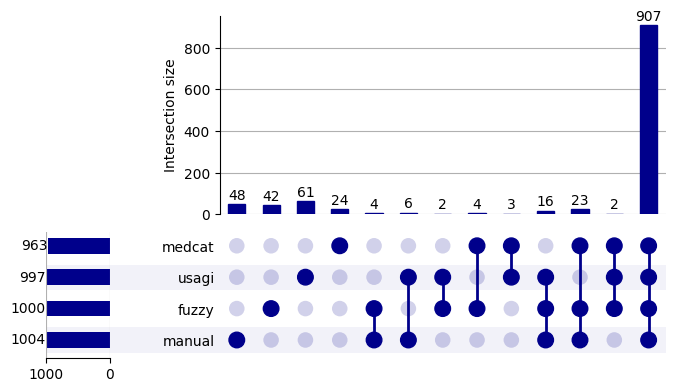

In [17]:
drawUpsetPlot(drugNdcDf)

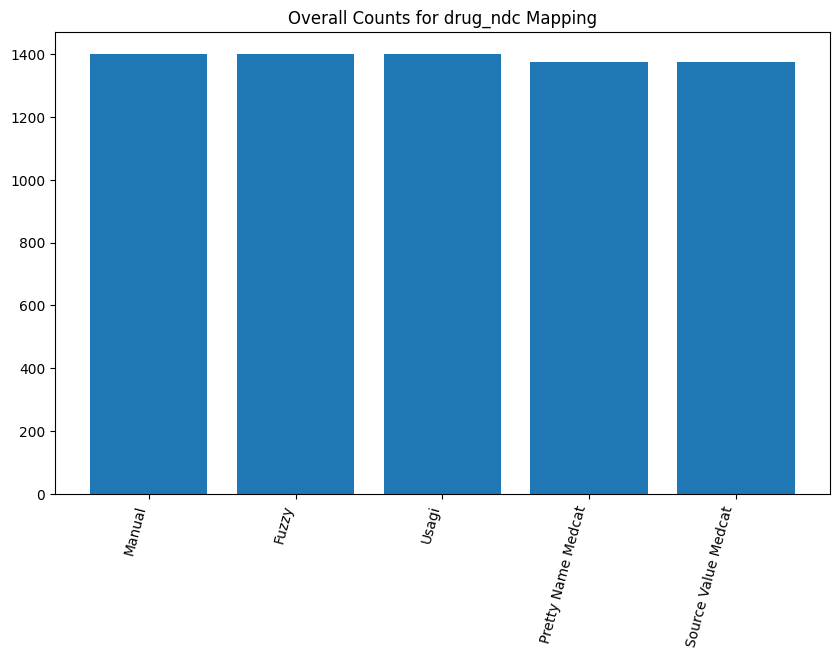

In [18]:
totalDrugNdcCounts = drawOverallCounts(mergedDf=drugNdcDf, conceptType='drug_ndc')
totalCounts['drug_ndc'] = totalDrugNdcCounts

In [19]:
drugNdcDf = calculateTextSimilarity(drugNdcDf)

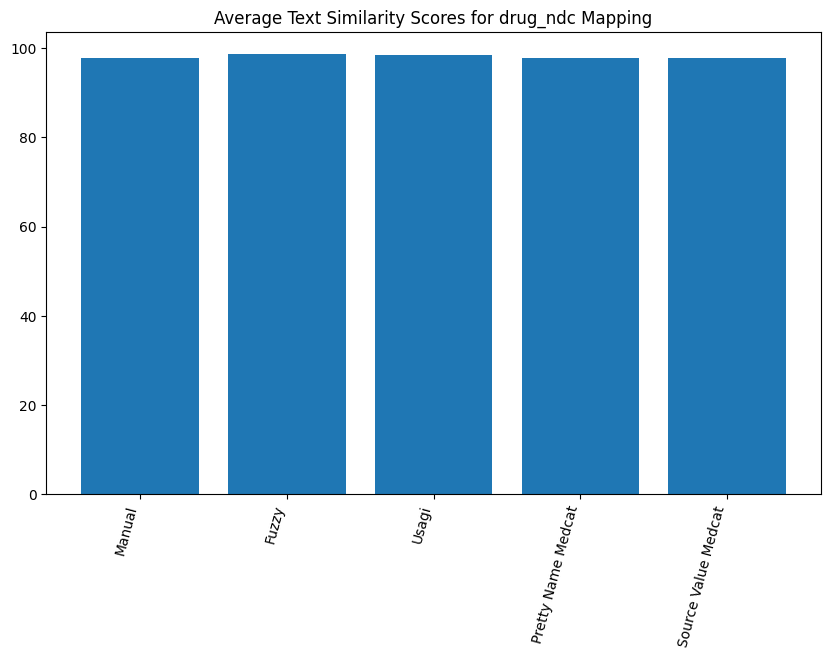

In [20]:
drugNdcTextSimilarityScores = drawAverageTextSimilarityScores(mergedDf=drugNdcDf, conceptType='drug_ndc')
textSimilarityScores['drug_ndc'] = drugNdcTextSimilarityScores

In [21]:
drugNdcDf = calculateSemanticSimilarity(drugNdcDf)

/home/yram0006/phd/chapter_1/workspace/EHRQC/.venv/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/home/yram0006/phd/chapter_1/workspace/EHRQC/.venv/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

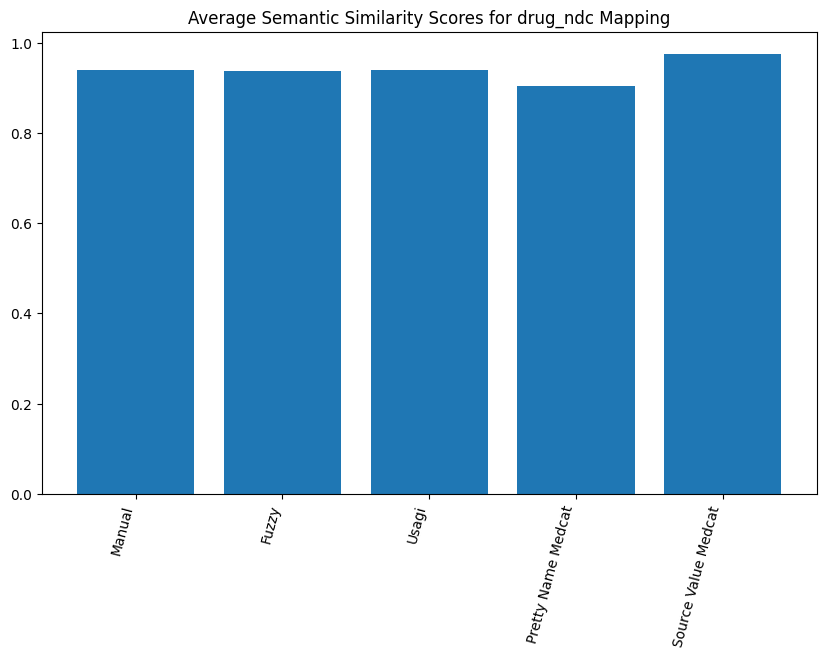

In [22]:
drugNdcSemanticSimilarityScores = drawAverageSemanticSimilarityScores(mergedDf=drugNdcDf, conceptType='drug_ndc')
semanticSimilarityScores['drug_ndc'] = drugNdcSemanticSimilarityScores

## `2. mimiciv_micro_organism`

In [23]:
microOrganismDf = createCombinedDataframe(conceptType='mimiciv_micro_organism', vocabularyType='snomed', conceptsDf=conceptsDf, usagiDf=usagiDf)
microOrganismDf

,concept_name,concept_code,source_concept_id,source_vocabulary_id,source_domain_id,source_concept_class_id,target_concept_id,relationship_id,reverese_relationship_id,concept_name_con,...,matching_vocabulary_medcat,source_concept_id_fuzzy,source_concept_name_fuzzy,source_vocabulary_id_fuzzy,matching_concept_name_fuzzy,matching_concept_id_fuzzy,matching_concept_score_fuzzy,matching_vocabulary_fuzzy,matching_pretty_name_medcat,matching_source_value_medcat
0,ESCHERICHIA COLI,80002,2000026001,mimiciv_micro_organism,Observation,Organism,4011683,Maps to,Mapped from,Escherichia coli,...,SNOMED,2000026001,ESCHERICHIA COLI,mimiciv_micro_organism,Escherichia coli,4011683,100,SNOMED,Escherichia Coli,ESCHERICHIA COLI
1,GRAM NEGATIVE COCCI,80003,2000026002,mimiciv_micro_organism,Observation,Organism,4081940,Maps to,Mapped from,Gram-negative coccus,...,SNOMED,2000026002,GRAM NEGATIVE COCCI,mimiciv_micro_organism,Gram-negative coccus,4081940,92,SNOMED,Negative,NEGATIVE
2,KLEBSIELLA PNEUMONIAE,80004,2000026003,mimiciv_micro_organism,Observation,Organism,4209452,Maps to,Mapped from,Klebsiella pneumoniae,...,SNOMED,2000026003,KLEBSIELLA PNEUMONIAE,mimiciv_micro_organism,Klebsiella pneumoniae,4209452,100,SNOMED,Klebsiella Pneumoniae,KLEBSIELLA PNEUMONIAE
3,KLEBSIELLA OXYTOCA,80005,2000026004,mimiciv_micro_organism,Observation,Organism,4254213,Maps to,Mapped from,Klebsiella oxytoca,...,SNOMED,2000026004,KLEBSIELLA OXYTOCA,mimiciv_micro_organism,Klebsiella oxytoca,4254213,100,SNOMED,Klebsiella Oxytoca,KLEBSIELLA OXYTOCA
4,KLEBSIELLA OZAENAE,80006,2000026005,mimiciv_micro_organism,Observation,Organism,4275741,Maps to,Mapped from,Klebsiella pneumoniae ss. ozaenae,...,SNOMED,2000026005,KLEBSIELLA OZAENAE,mimiciv_micro_organism,Klebsiella oxytoca,4254213,72,SNOMED,Klebsiella,KLEBSIELLA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,STAPHYLOCOCCUS PSEUDINTERMEDIUS,90809,2000026360,mimiciv_micro_organism,Observation,Organism,4142864,Maps to,Mapped from,Staphylococcus pseudintermedius,...,SNOMED,2000026360,STAPHYLOCOCCUS PSEUDINTERMEDIUS,mimiciv_micro_organism,Staphylococcus pseudintermedius,4142864,100,SNOMED,Staphylococcus Pseudintermedius,STAPHYLOCOCCUS PSEUDINTERMEDIUS
360,AEROCOCCUS URINAE,90812,2000026361,mimiciv_micro_organism,Observation,Organism,4347674,Maps to,Mapped from,Aerococcus urinae,...,SNOMED,2000026361,AEROCOCCUS URINAE,mimiciv_micro_organism,Aerococcus urinae,4347674,100,SNOMED,Aerococcus Urinae,AEROCOCCUS URINAE
361,RAOULTELLA PLANTICOLA,90815,2000026362,mimiciv_micro_organism,Observation,Organism,4166421,Maps to,Mapped from,Raoultella planticola,...,SNOMED,2000026362,RAOULTELLA PLANTICOLA,mimiciv_micro_organism,Raoultella planticola,4166421,100,SNOMED,Raoultella Planticola,RAOULTELLA PLANTICOLA
362,STREPTOCOCCUS GORDONII,90830,2000026363,mimiciv_micro_organism,Observation,Organism,4015115,Maps to,Mapped from,Streptococcus gordonii,...,SNOMED,2000026363,STREPTOCOCCUS GORDONII,mimiciv_micro_organism,Streptococcus gordonii,4015115,100,SNOMED,Streptococcus Gordonii,STREPTOCOCCUS GORDONII


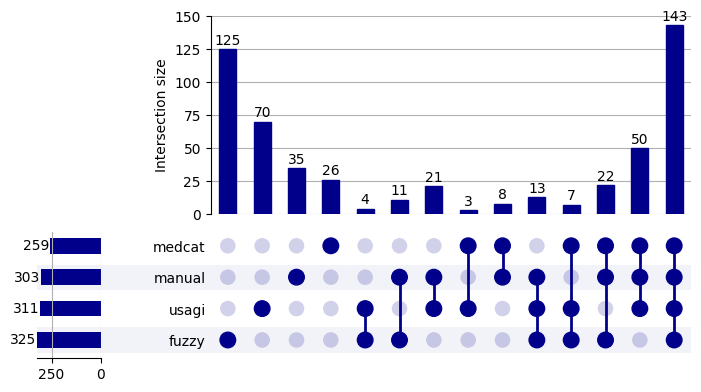

In [24]:
drawUpsetPlot(microOrganismDf)

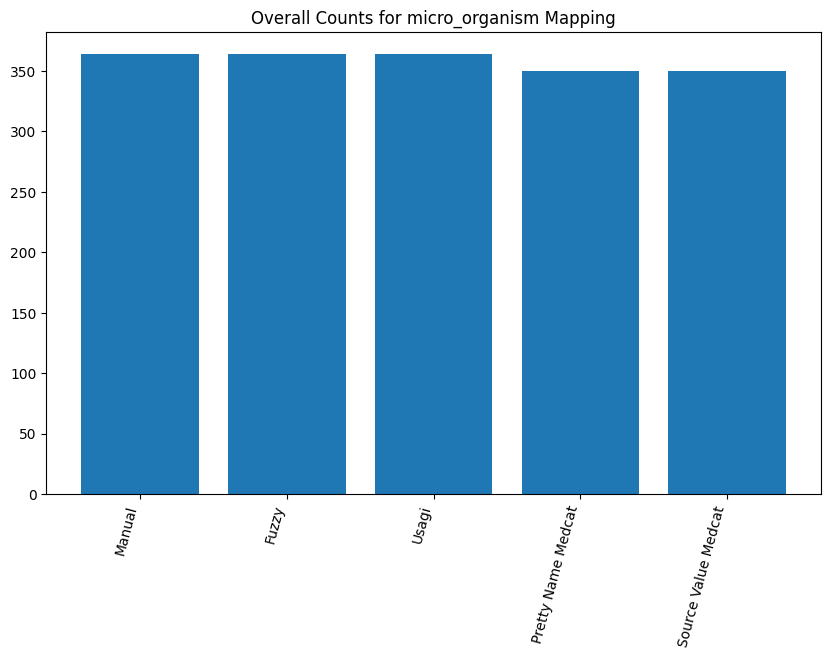

In [25]:
totalMicroOrganismCounts = drawOverallCounts(mergedDf=microOrganismDf, conceptType='micro_organism')
totalCounts['micro_organism'] = totalMicroOrganismCounts

In [26]:
microOrganismDf = calculateTextSimilarity(microOrganismDf)

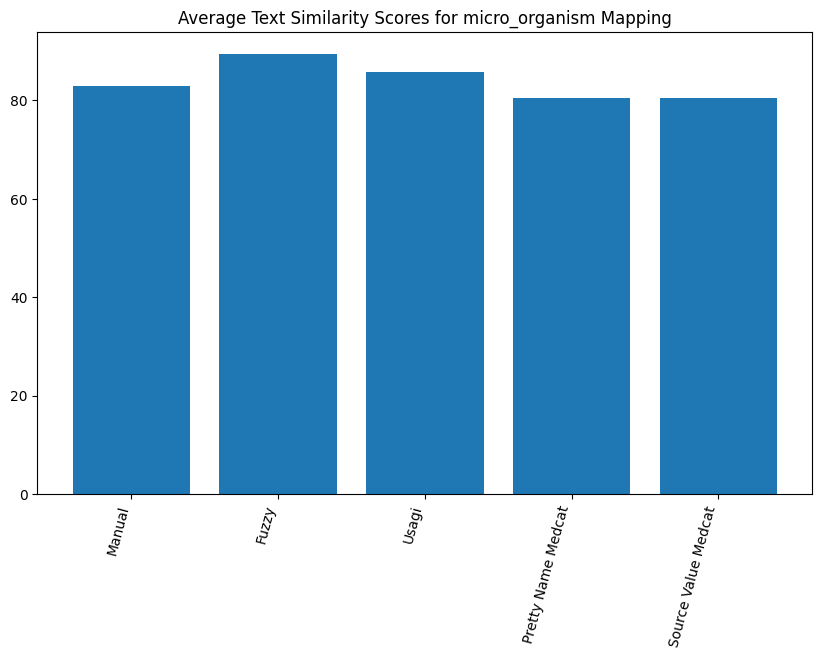

In [27]:
microOrganismTextSimilarityScores = drawAverageTextSimilarityScores(mergedDf=microOrganismDf, conceptType='micro_organism')
textSimilarityScores['micro_organism'] = microOrganismTextSimilarityScores

In [28]:
microOrganismDf = calculateSemanticSimilarity(microOrganismDf)

/home/yram0006/phd/chapter_1/workspace/EHRQC/.venv/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/home/yram0006/phd/chapter_1/workspace/EHRQC/.venv/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

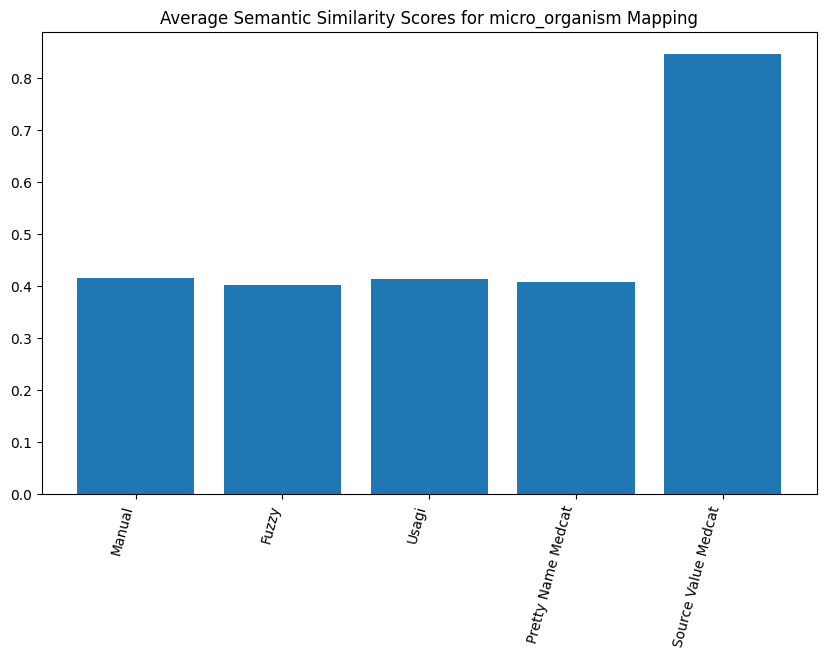

In [29]:
microOrganismSemanticSimilarityScores = drawAverageSemanticSimilarityScores(mergedDf=microOrganismDf, conceptType='micro_organism')
semanticSimilarityScores['micro_organism'] = microOrganismSemanticSimilarityScores

## `3. mimiciv_meas_lab_loinc`

In [30]:
measurementsLabDf = createCombinedDataframe(conceptType='mimiciv_meas_lab_loinc', vocabularyType='loinc', conceptsDf=conceptsDf, usagiDf=usagiDf)
measurementsLabDf

,concept_name,concept_code,source_concept_id,source_vocabulary_id,source_domain_id,source_concept_class_id,target_concept_id,relationship_id,reverese_relationship_id,concept_name_con,...,matching_vocabulary_medcat,source_concept_id_fuzzy,source_concept_name_fuzzy,source_vocabulary_id_fuzzy,matching_concept_name_fuzzy,matching_concept_id_fuzzy,matching_concept_score_fuzzy,matching_vocabulary_fuzzy,matching_pretty_name_medcat,matching_source_value_medcat
0,Alveolar-arterial Gradient|Blood|Blood Gas,50801,2000001001,mimiciv_meas_lab_loinc,Measurement,Lab Test,3007913,Maps to,Mapped from,Alveolar-arterial oxygen Partial pressure diff...,...,LOINC,2000001001,Alveolar-arterial Gradient|Blood|Blood Gas,mimiciv_meas_lab_loinc,Gas panel - Arterial cord blood,3042095,68,LOINC,Alveolar,Alveolar
1,Base Excess|Blood|Blood Gas,50802,2000001002,mimiciv_meas_lab_loinc,Measurement,Lab Test,3012501,Maps to,Mapped from,Base excess in Blood by calculation,...,LOINC,2000001002,Base Excess|Blood|Blood Gas,mimiciv_meas_lab_loinc,Base excess in Cord blood by calculation,3020320,72,LOINC,Base,Base
2,Calculated Total CO2|Blood|Blood Gas,50804,2000001003,mimiciv_meas_lab_loinc,Measurement,Lab Test,3031147,Maps to,Mapped from,"Carbon dioxide, total [Moles/volume] in Blood ...",...,LOINC,2000001003,Calculated Total CO2|Blood|Blood Gas,mimiciv_meas_lab_loinc,Stool occult blood,45877045,63,LOINC,Total,Total
3,"Chloride, Whole Blood|Blood|Blood Gas",50806,2000001004,mimiciv_meas_lab_loinc,Measurement,Lab Test,3018572,Maps to,Mapped from,Chloride [Moles/volume] in Blood,...,LOINC,2000001004,"Chloride, Whole Blood|Blood|Blood Gas",mimiciv_meas_lab_loinc,Whole blood given | Dose | Blood bank,37031873,70,LOINC,None,None
4,Free Calcium|Blood|Blood Gas,50808,2000001005,mimiciv_meas_lab_loinc,Measurement,Lab Test,3021119,Maps to,Mapped from,Calcium.ionized [Moles/volume] in Blood,...,LOINC,2000001005,Free Calcium|Blood|Blood Gas,mimiciv_meas_lab_loinc,Maximum blood flow rate by US,3044600,67,LOINC,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,"HCG, Urine, Qualitative|Urine|Chemistry",52715,2000001247,mimiciv_meas_lab_loinc,Measurement,Lab Test,3018954,Maps to,Mapped from,Choriogonadotropin (pregnancy test) [Presence]...,...,LOINC,2000001247,"HCG, Urine, Qualitative|Urine|Chemistry",mimiciv_meas_lab_loinc,Taurine | Urine | Chemistry - non-challenge,37066667,65,LOINC,Hcg,HCG
247,pH|Urine|Chemistry,52725,2000001248,mimiciv_meas_lab_loinc,Measurement,Lab Test,3015736,Maps to,Mapped from,pH of Urine,...,LOINC,2000001248,pH|Urine|Chemistry,mimiciv_meas_lab_loinc,Chemistry Panels,37069277,76,LOINC,None,None
248,Absolute Lymphocyte Count|Blood|Hematology,52764,2000001249,mimiciv_meas_lab_loinc,Measurement,Lab Test,3019198,Maps to,Mapped from,Lymphocytes [#/volume] in Blood,...,LOINC,2000001249,Absolute Lymphocyte Count|Blood|Hematology,mimiciv_meas_lab_loinc,Lymphocytes | Blood | Hematology and Cell counts,37060904,81,LOINC,None,None
249,NRBC|Joint Fluid|Hematology,53007,2000001250,mimiciv_meas_lab_loinc,Measurement,Lab Test,40771130,Maps to,Mapped from,Nucleated erythrocytes/100 leukocytes [Ratio] ...,...,LOINC,2000001250,NRBC|Joint Fluid|Hematology,mimiciv_meas_lab_loinc,Hematology Initial evaluation note,21492356,66,LOINC,Fluid,Fluid


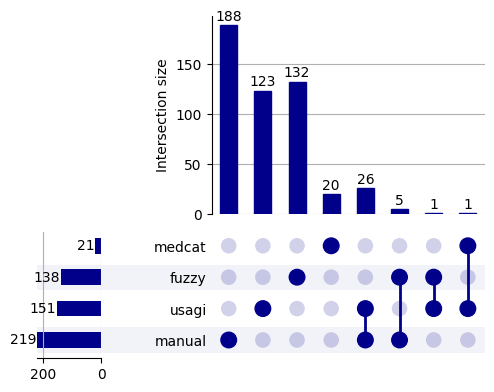

In [31]:
drawUpsetPlot(measurementsLabDf)

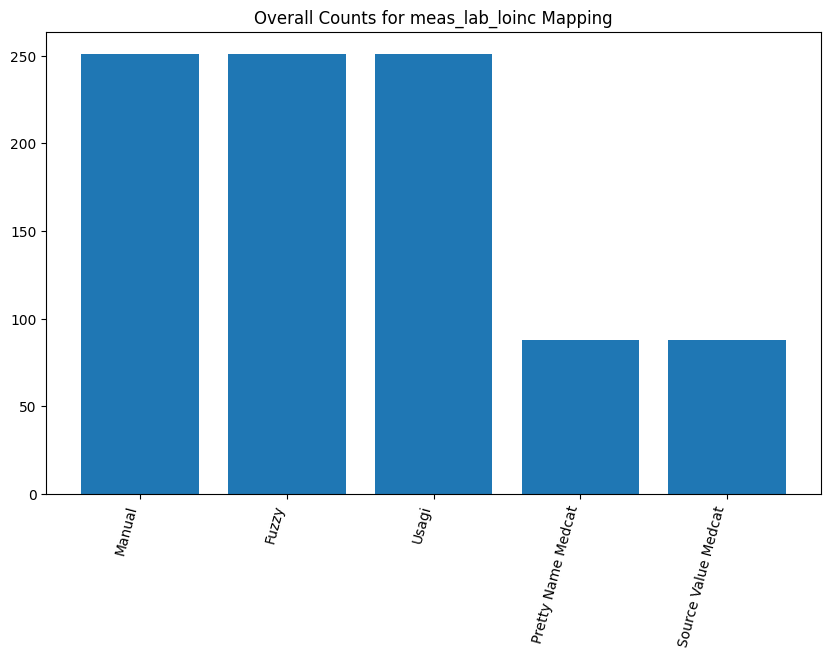

In [32]:
totalMeasurementsLabCounts = drawOverallCounts(mergedDf=measurementsLabDf, conceptType='meas_lab_loinc')
totalCounts['meas_lab_loinc'] = totalMeasurementsLabCounts

In [33]:
measurementsLabDf = calculateTextSimilarity(measurementsLabDf)

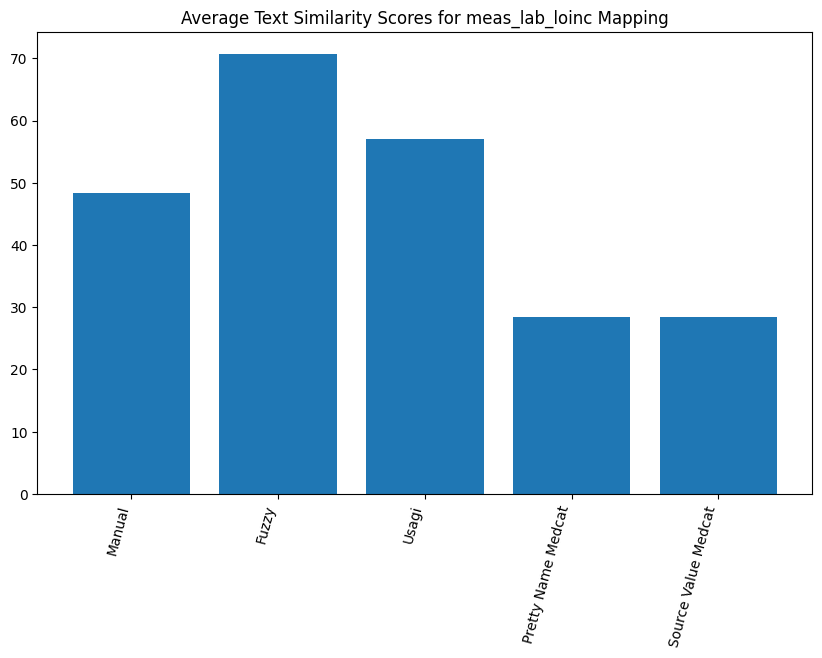

In [34]:
measurementsLabTextSimilarityScores = drawAverageTextSimilarityScores(mergedDf=measurementsLabDf, conceptType='meas_lab_loinc')
textSimilarityScores['meas_lab_loinc'] = measurementsLabTextSimilarityScores

In [35]:
measurementsLabDf = calculateSemanticSimilarity(measurementsLabDf)

/home/yram0006/phd/chapter_1/workspace/EHRQC/.venv/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/home/yram0006/phd/chapter_1/workspace/EHRQC/.venv/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

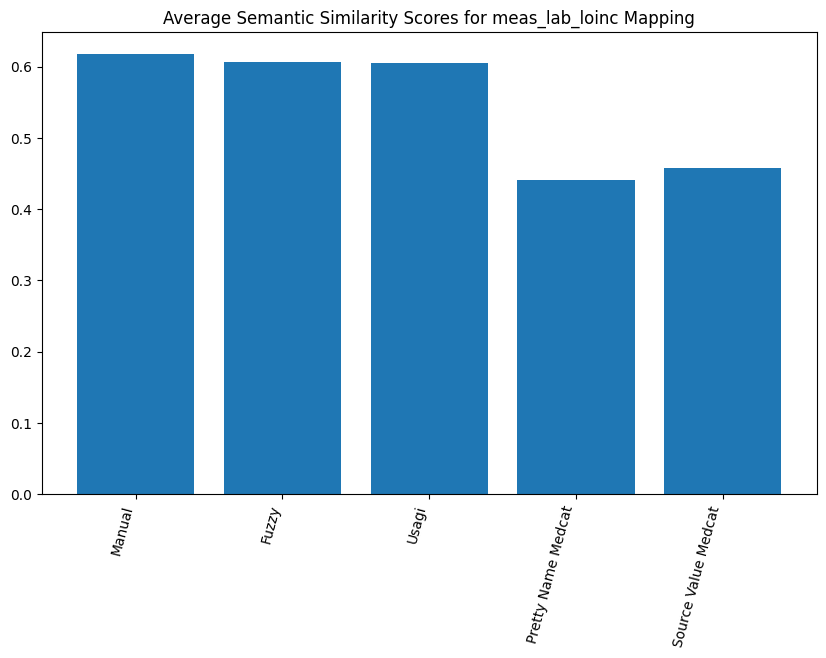

In [36]:
measurementsLabSemanticSimilarityScores = drawAverageSemanticSimilarityScores(mergedDf=measurementsLabDf, conceptType='meas_lab_loinc')
semanticSimilarityScores['meas_lab_loinc'] = measurementsLabSemanticSimilarityScores

## `4. mimiciv_proc_datetimeevents`

In [37]:
datetimeeventsDf = createCombinedDataframe(conceptType='mimiciv_proc_datetimeevents', vocabularyType='snomed', conceptsDf=conceptsDf, usagiDf=usagiDf)
datetimeeventsDf

,concept_name,concept_code,source_concept_id,source_vocabulary_id,source_domain_id,source_concept_class_id,target_concept_id,relationship_id,reverese_relationship_id,concept_name_con,...,matching_vocabulary_medcat,source_concept_id_fuzzy,source_concept_name_fuzzy,source_vocabulary_id_fuzzy,matching_concept_name_fuzzy,matching_concept_id_fuzzy,matching_concept_score_fuzzy,matching_vocabulary_fuzzy,matching_pretty_name_medcat,matching_source_value_medcat
0,PICC Line Cap Change,224183,2000004001,mimiciv_proc_datetimeevents,Procedure,Procedure,4078442,Maps to,Mapped from,Catheter procedure,...,SNOMED,2000004001,PICC Line Cap Change,mimiciv_proc_datetimeevents,Change in voice,4164647,69,SNOMED,Line,Line
1,PICC Line Insertion Date,224184,2000004002,mimiciv_proc_datetimeevents,Procedure,Procedure,4322380,Maps to,Mapped from,Insertion of peripherally inserted central cat...,...,SNOMED,2000004002,PICC Line Insertion Date,mimiciv_proc_datetimeevents,Line insertion site,4300975,74,SNOMED,Line,Line
2,PICC Line Change over Wire Date,224185,2000004003,mimiciv_proc_datetimeevents,Procedure,Procedure,4322380,Maps to,Mapped from,Insertion of peripherally inserted central cat...,...,SNOMED,2000004003,PICC Line Change over Wire Date,mimiciv_proc_datetimeevents,Vascular line exchange over wire,4214294,73,SNOMED,Line,Line
3,PICC Line Dressing Change,224186,2000004004,mimiciv_proc_datetimeevents,Procedure,Procedure,4078442,Maps to,Mapped from,Catheter procedure,...,SNOMED,2000004004,PICC Line Dressing Change,mimiciv_proc_datetimeevents,"Change of dressing, minor",4085478,78,SNOMED,Line,Line
4,PICC Line Tubing Change,224187,2000004005,mimiciv_proc_datetimeevents,Procedure,Procedure,4078442,Maps to,Mapped from,Catheter procedure,...,SNOMED,2000004005,PICC Line Tubing Change,mimiciv_proc_datetimeevents,Does change position,4120479,65,SNOMED,Line,Line
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,Tandem Heart Access Line Insertion Date,228209,2000004125,mimiciv_proc_datetimeevents,Procedure,Procedure,4078442,Maps to,Mapped from,Catheter procedure,...,SNOMED,2000004125,Tandem Heart Access Line Insertion Date,mimiciv_proc_datetimeevents,Urinary catheter insertion assessment,4259348,63,SNOMED,Access,Access
125,Tandem Heart Access Line Tubing Change,228215,2000004126,mimiciv_proc_datetimeevents,Procedure,Procedure,4078442,Maps to,Mapped from,Catheter procedure,...,SNOMED,2000004126,Tandem Heart Access Line Tubing Change,mimiciv_proc_datetimeevents,Checking ear mold and tubing,4021509,61,SNOMED,Access,Access
126,Tandem Heart Return Cannula Dressing Change,228218,2000004127,mimiciv_proc_datetimeevents,Procedure,Procedure,4078442,Maps to,Mapped from,Catheter procedure,...,SNOMED,2000004127,Tandem Heart Return Cannula Dressing Change,mimiciv_proc_datetimeevents,Change of dressing in external auditory canal,4339462,64,SNOMED,Cannula,Cannula
127,Tandem Heart Return Cannula Insertion Date,228221,2000004128,mimiciv_proc_datetimeevents,Procedure,Procedure,4078442,Maps to,Mapped from,Catheter procedure,...,SNOMED,2000004128,Tandem Heart Return Cannula Insertion Date,mimiciv_proc_datetimeevents,Portal vein cannula insertion,4051311,62,SNOMED,Cannula,Cannula


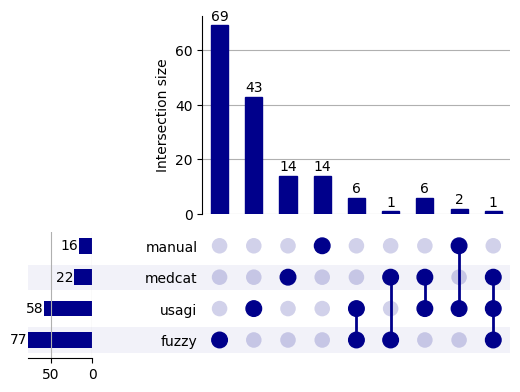

In [38]:
drawUpsetPlot(datetimeeventsDf)

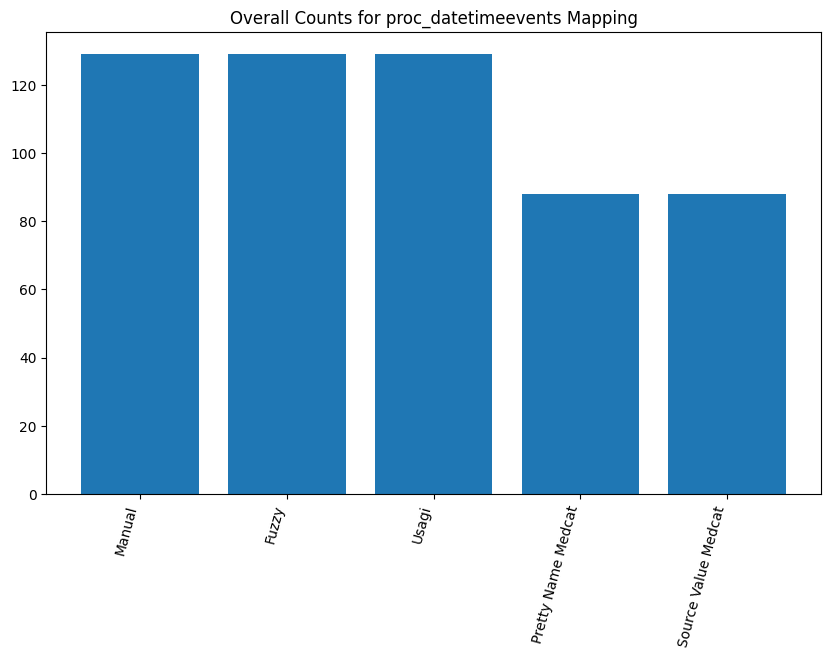

In [39]:

totalDatetimeeventsCounts = drawOverallCounts(mergedDf=datetimeeventsDf, conceptType='proc_datetimeevents')
totalCounts['proc_datetimeevents'] = totalDatetimeeventsCounts

In [40]:
datetimeeventsDf = calculateTextSimilarity(datetimeeventsDf)

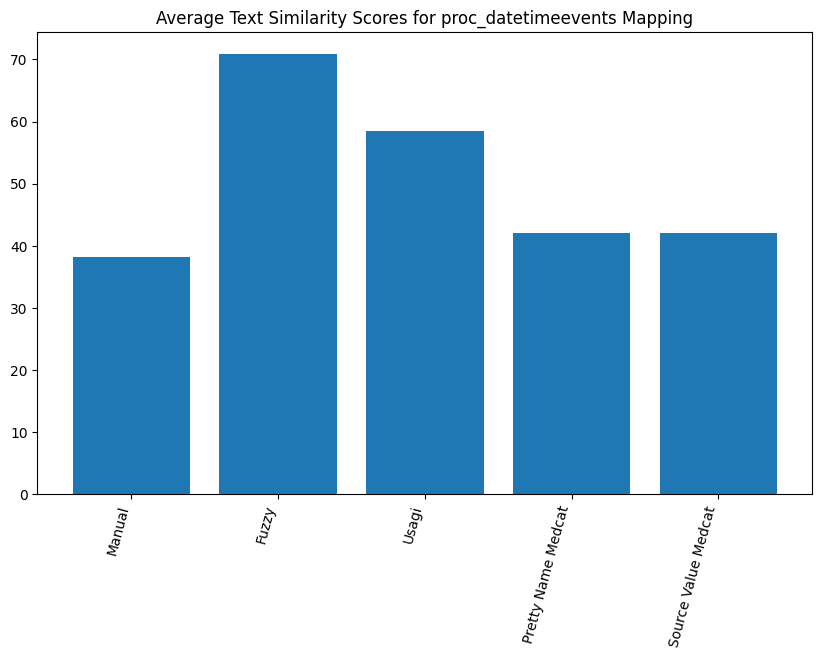

In [41]:
datetimeeventsTextSimilarityScores = drawAverageTextSimilarityScores(mergedDf=datetimeeventsDf, conceptType='proc_datetimeevents')
textSimilarityScores['proc_datetimeevents'] = datetimeeventsTextSimilarityScores

In [42]:
datetimeeventsDf = calculateSemanticSimilarity(datetimeeventsDf)

/home/yram0006/phd/chapter_1/workspace/EHRQC/.venv/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/home/yram0006/phd/chapter_1/workspace/EHRQC/.venv/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

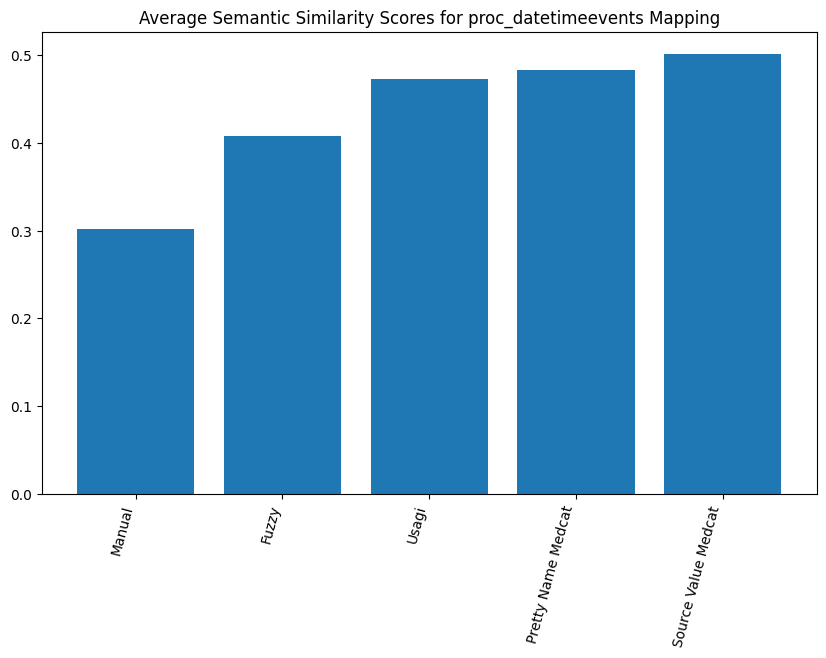

In [43]:
datetimeeventsSemanticSimilarityScores = drawAverageSemanticSimilarityScores(mergedDf=datetimeeventsDf, conceptType='proc_datetimeevents')
semanticSimilarityScores['proc_datetimeevents'] = datetimeeventsSemanticSimilarityScores

## `5. mimiciv_drug_route`

In [44]:
drugRouteDf = createCombinedDataframe(conceptType='mimiciv_drug_route', vocabularyType='snomed', conceptsDf=conceptsDf, usagiDf=usagiDf)
drugRouteDf

,concept_name,concept_code,source_concept_id,source_vocabulary_id,source_domain_id,source_concept_class_id,target_concept_id,relationship_id,reverese_relationship_id,concept_name_con,...,matching_vocabulary_medcat,source_concept_id_fuzzy,source_concept_name_fuzzy,source_vocabulary_id_fuzzy,matching_concept_name_fuzzy,matching_concept_id_fuzzy,matching_concept_score_fuzzy,matching_vocabulary_fuzzy,matching_pretty_name_medcat,matching_source_value_medcat
0,IV,IV,2000002001,mimiciv_drug_route,Route,Qualifier Value,4171047,Maps to,Mapped from,Intravenous route,...,SNOMED,2000002001,IV,mimiciv_drug_route,IV,4125539,100,SNOMED,None,None
1,PO/NG,PO/NG,2000002002,mimiciv_drug_route,Route,Qualifier Value,4167540,Maps to,Mapped from,Enteral route,...,SNOMED,2000002002,PO/NG,mimiciv_drug_route,pmol/g,4216137,73,SNOMED,None,None
2,PO,PO,2000002003,mimiciv_drug_route,Route,Qualifier Value,4132161,Maps to,Mapped from,Oral route,...,SNOMED,2000002003,PO,mimiciv_drug_route,Poi,4135269,80,SNOMED,None,None
3,SC,SC,2000002004,mimiciv_drug_route,Route,Qualifier Value,4142048,Maps to,Mapped from,Subcutaneous route,...,SNOMED,2000002004,SC,mimiciv_drug_route,Scar,4050007,67,SNOMED,None,None
4,IV DRIP,IV DRIP,2000002005,mimiciv_drug_route,Route,Qualifier Value,4171047,Maps to,Mapped from,Intravenous route,...,SNOMED,2000002005,IV DRIP,mimiciv_drug_route,Dripping,4037098,67,SNOMED,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Nasal,NU,2000002092,mimiciv_drug_route,Route,Qualifier Value,4262914,Maps to,Mapped from,Nasal route,...,SNOMED,2000002092,Nasal,mimiciv_drug_route,Nasal,4128792,100,SNOMED,None,None
92,Haemodialysis,REPLACE,2000002093,mimiciv_drug_route,Route,Qualifier Value,45956871,Maps to,Mapped from,Haemodialysis,...,SNOMED,2000002093,Haemodialysis,mimiciv_drug_route,Haemodialysis,45956871,100,SNOMED,Haemodialysis,Haemodialysis
93,Intravenous,PB,2000002094,mimiciv_drug_route,Route,Qualifier Value,4171047,Maps to,Mapped from,Intravenous route,...,SNOMED,2000002094,Intravenous,mimiciv_drug_route,Intravenous,4112421,100,SNOMED,Intravenous,Intravenous
94,Intravenous,PAL,2000002095,mimiciv_drug_route,Route,Qualifier Value,4171047,Maps to,Mapped from,Intravenous route,...,SNOMED,2000002095,Intravenous,mimiciv_drug_route,Intravenous,4112421,100,SNOMED,Intravenous,Intravenous


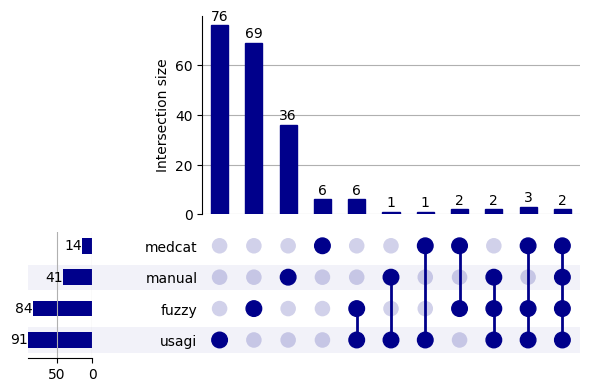

In [45]:
drawUpsetPlot(drugRouteDf)

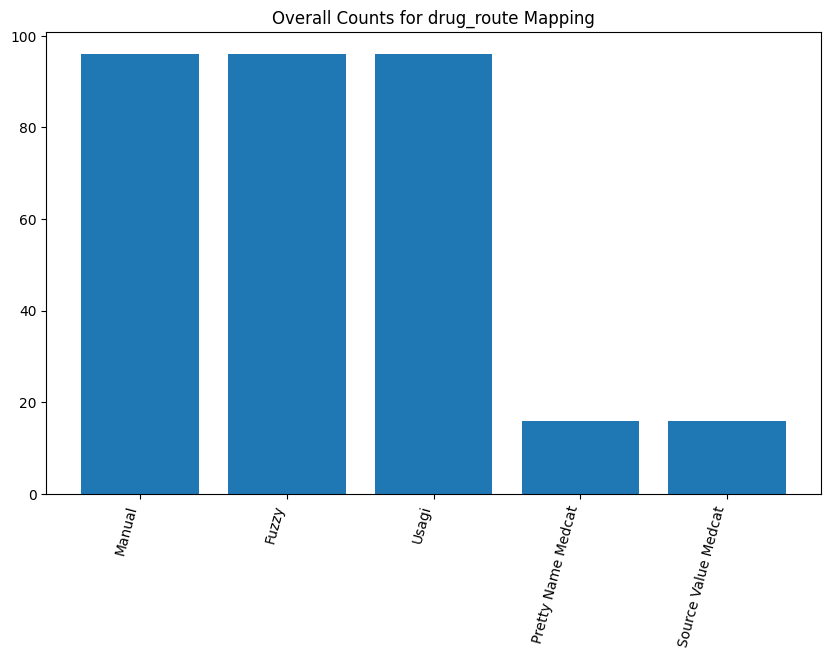

In [46]:
totalDrugRouteCounts = drawOverallCounts(mergedDf=drugRouteDf, conceptType='drug_route')
totalCounts['drug_route'] = totalDrugRouteCounts

In [47]:
drugRouteDf = calculateTextSimilarity(drugRouteDf)

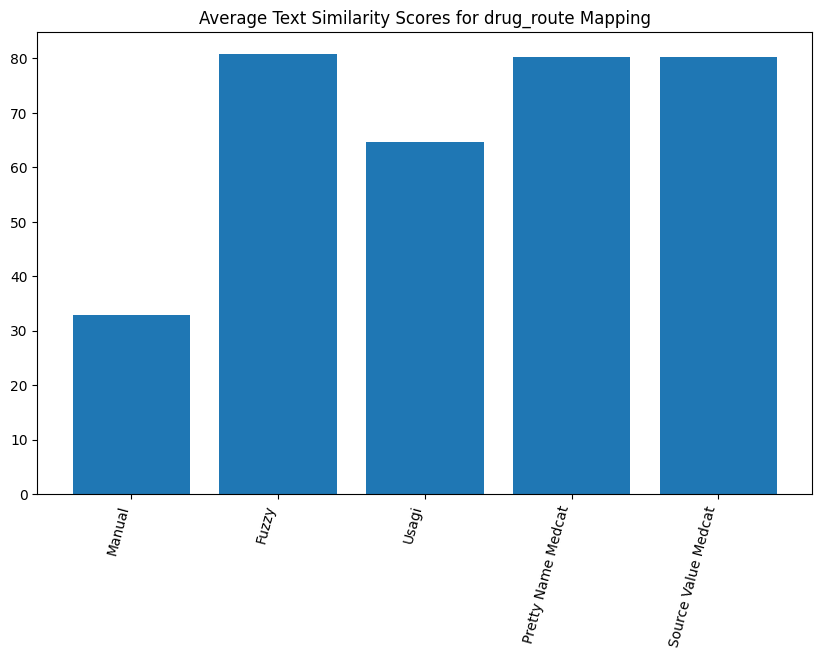

In [48]:
drugRouteTextSimilarityScores = drawAverageTextSimilarityScores(mergedDf=drugRouteDf, conceptType='drug_route')
textSimilarityScores['drug_route'] = drugRouteTextSimilarityScores

In [49]:
drugRouteDf = calculateSemanticSimilarity(drugRouteDf)

/home/yram0006/phd/chapter_1/workspace/EHRQC/.venv/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/home/yram0006/phd/chapter_1/workspace/EHRQC/.venv/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

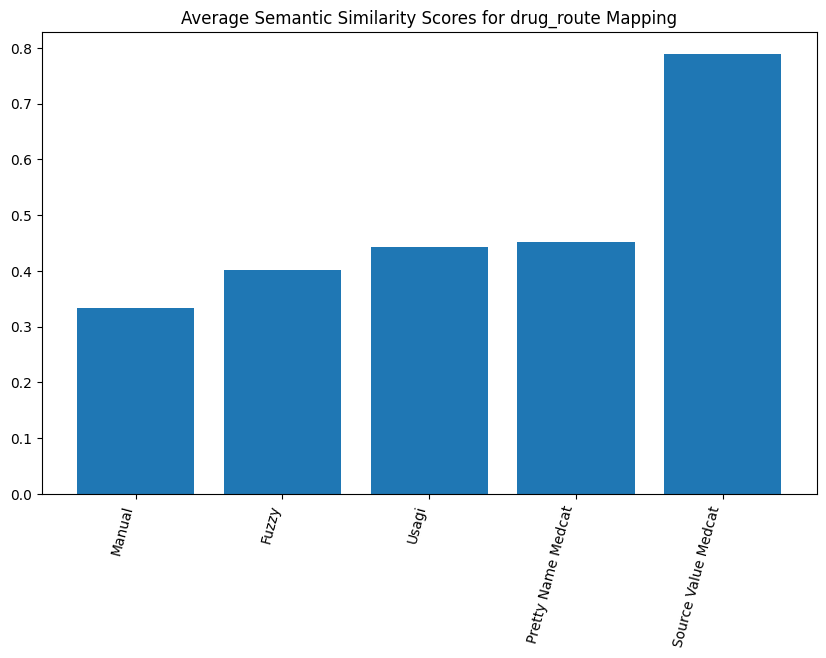

In [50]:
drugRouteSemanticSimilarityScores = drawAverageSemanticSimilarityScores(mergedDf=drugRouteDf, conceptType='drug_route')
semanticSimilarityScores['drug_route'] = drugRouteSemanticSimilarityScores

## Summary plots

In [51]:
totalCounts['proportion_drug_ndc'] = list(map(lambda x: x/drugNdcDf.shape[0]*100, totalCounts['drug_ndc']))
totalCounts['proportion_micro_organism'] = list(map(lambda x: x/microOrganismDf.shape[0]*100, totalCounts['micro_organism']))
totalCounts['proportion_meas_lab_loinc'] = list(map(lambda x: x/measurementsLabDf.shape[0]*100, totalCounts['meas_lab_loinc']))
totalCounts['proportion_proc_datetimeevents'] = list(map(lambda x: x/datetimeeventsDf.shape[0]*100, totalCounts['proc_datetimeevents']))
totalCounts['proportion_drug_route'] = list(map(lambda x: x/drugRouteDf.shape[0]*100, totalCounts['drug_route']))

In [52]:
manualProportions = [totalCounts[key][0] for key in totalCounts.keys() if key.startswith('proportion')]
fuzzyProportions = [totalCounts[key][1] for key in totalCounts.keys() if key.startswith('proportion')]
usagiProportions = [totalCounts[key][2] for key in totalCounts.keys() if key.startswith('proportion')]
medcatProportions = [totalCounts[key][4] for key in totalCounts.keys() if key.startswith('proportion')]
labels = ['drug_ndc', 'micro_organism', 'meas_lab_loinc', 'proc_datetimeevents', 'drug_route']

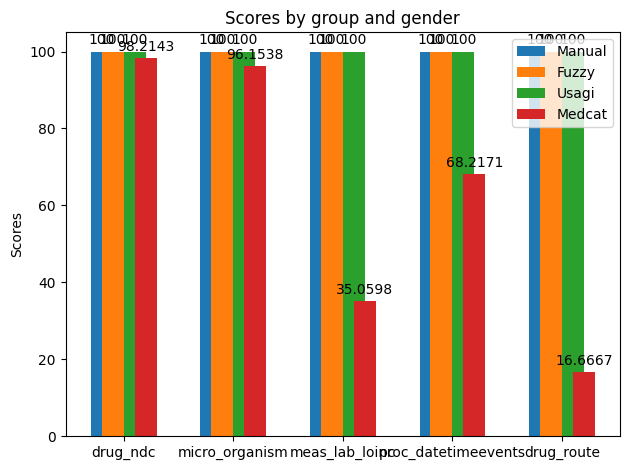

In [53]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width/2, manualProportions, width, label='Manual')
rects2 = ax.bar(x - width/2, fuzzyProportions, width, label='Fuzzy')
rects3 = ax.bar(x + width/2, usagiProportions, width, label='Usagi')
rects4 = ax.bar(x + 2*width/2, medcatProportions, width, label='Medcat')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)

fig.tight_layout()

plt.show()

In [54]:
manualTextSimilarityScores = [textSimilarityScores[key][0] for key in textSimilarityScores.keys()]
fuzzyTextSimilarityScores = [textSimilarityScores[key][1] for key in textSimilarityScores.keys()]
usagiTextSimilarityScores = [textSimilarityScores[key][2] for key in textSimilarityScores.keys()]
medcatTextSimilarityScores = [textSimilarityScores[key][4] for key in textSimilarityScores.keys()]
labels = ['drug_ndc', 'micro_organism', 'meas_lab_loinc', 'proc_datetimeevents', 'drug_route']

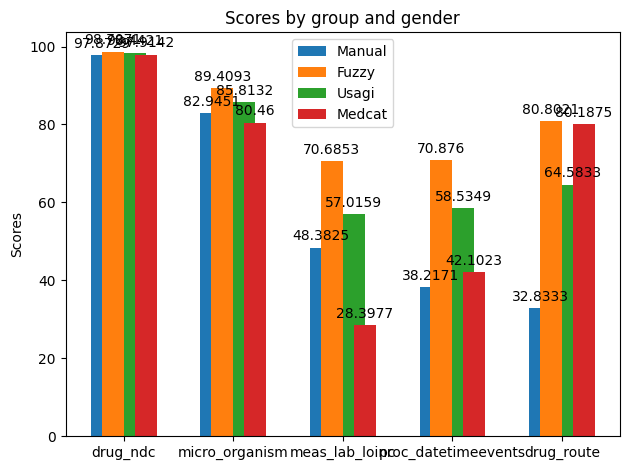

In [55]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width/2, manualTextSimilarityScores, width, label='Manual')
rects2 = ax.bar(x - width/2, fuzzyTextSimilarityScores, width, label='Fuzzy')
rects3 = ax.bar(x + width/2, usagiTextSimilarityScores, width, label='Usagi')
rects4 = ax.bar(x + 2*width/2, medcatTextSimilarityScores, width, label='Medcat')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)

fig.tight_layout()

plt.show()

In [56]:
manualSemanticSimilarityScores = [semanticSimilarityScores[key][0] for key in semanticSimilarityScores.keys()]
fuzzySemanticSimilarityScores = [semanticSimilarityScores[key][1] for key in semanticSimilarityScores.keys()]
usagiSemanticSimilarityScores = [semanticSimilarityScores[key][2] for key in semanticSimilarityScores.keys()]
medcatSemanticSimilarityScores = [semanticSimilarityScores[key][4] for key in semanticSimilarityScores.keys()]
labels = ['drug_ndc', 'micro_organism', 'meas_lab_loinc', 'proc_datetimeevents', 'drug_route']

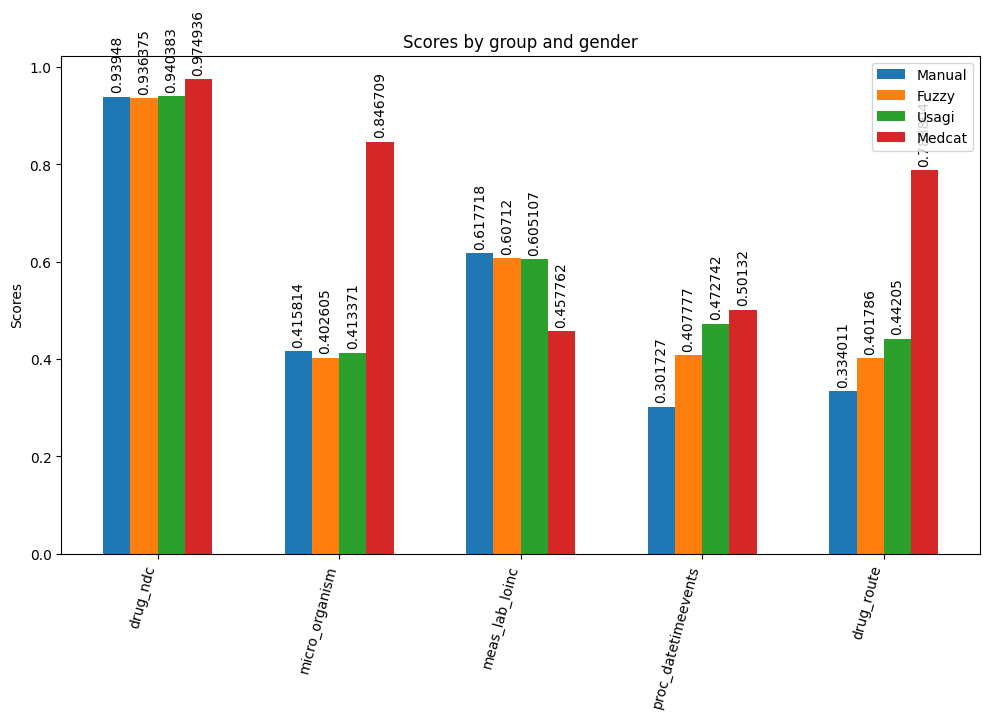

In [57]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 3*width/2, manualSemanticSimilarityScores, width, label='Manual')
rects2 = ax.bar(x - width/2, fuzzySemanticSimilarityScores, width, label='Fuzzy')
rects3 = ax.bar(x + width/2, usagiSemanticSimilarityScores, width, label='Usagi')
rects4 = ax.bar(x + 3*width/2, medcatSemanticSimilarityScores, width, label='Medcat')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, rotation=90)
ax.bar_label(rects2, padding=3, rotation=90)
ax.bar_label(rects3, padding=3, rotation=90)
ax.bar_label(rects4, padding=3, rotation=90)

fig.tight_layout()
plt.xticks(rotation=75, ha='right')
plt.show()

## Summary plots for Symposium

In [58]:
manualProportions = [totalCounts[key][0] for key in totalCounts.keys() if key in ['proportion_drug_ndc', 'proportion_micro_organism', 'proportion_proc_datetimeevents']]
fuzzyProportions = [totalCounts[key][1] for key in totalCounts.keys() if key in ['proportion_drug_ndc', 'proportion_micro_organism', 'proportion_proc_datetimeevents']]
usagiProportions = [totalCounts[key][2] for key in totalCounts.keys() if key in ['proportion_drug_ndc', 'proportion_micro_organism', 'proportion_proc_datetimeevents']]
medcatProportions = [totalCounts[key][4] for key in totalCounts.keys() if key in ['proportion_drug_ndc', 'proportion_micro_organism', 'proportion_proc_datetimeevents']]
labels = ['drug_ndc', 'micro_organism', 'proc_datetimeevents']

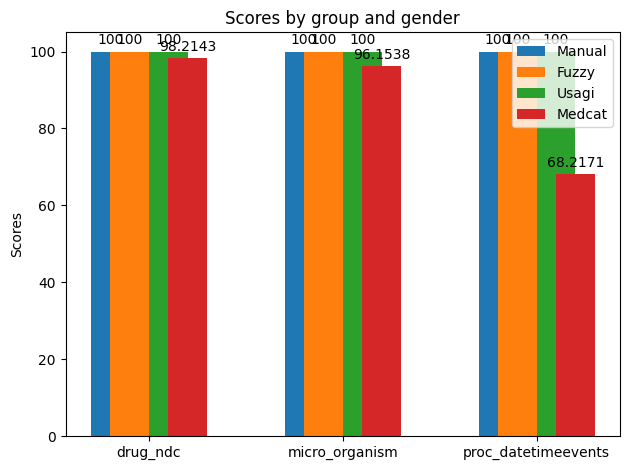

In [59]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width/2, manualProportions, width, label='Manual')
rects2 = ax.bar(x - width/2, fuzzyProportions, width, label='Fuzzy')
rects3 = ax.bar(x + width/2, usagiProportions, width, label='Usagi')
rects4 = ax.bar(x + 2*width/2, medcatProportions, width, label='Medcat')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)

fig.tight_layout()

plt.show()

In [69]:
manualTextSimilarityScores = [textSimilarityScores[key][0] for key in textSimilarityScores.keys() if key in ['drug_ndc', 'micro_organism', 'proc_datetimeevents']]
fuzzyTextSimilarityScores = [textSimilarityScores[key][1] for key in textSimilarityScores.keys() if key in ['drug_ndc', 'micro_organism', 'proc_datetimeevents']]
usagiTextSimilarityScores = [textSimilarityScores[key][2] for key in textSimilarityScores.keys() if key in ['drug_ndc', 'micro_organism', 'proc_datetimeevents']]
medcatTextSimilarityScores = [textSimilarityScores[key][4] for key in textSimilarityScores.keys() if key in ['drug_ndc', 'micro_organism', 'proc_datetimeevents']]
labels = ['drug_ndc', 'micro_organism', 'proc_datetimeevents']

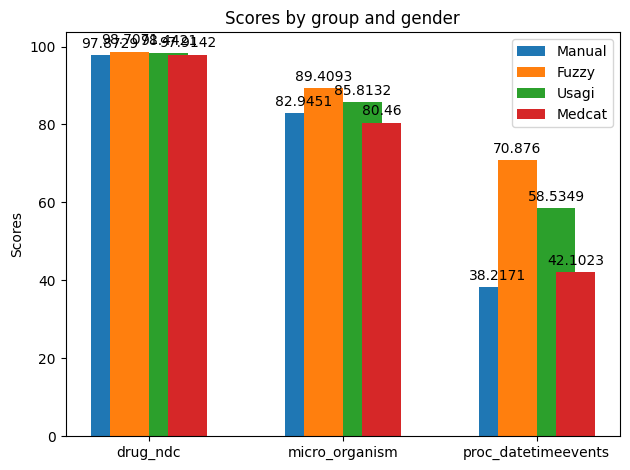

In [70]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width/2, manualTextSimilarityScores, width, label='Manual')
rects2 = ax.bar(x - width/2, fuzzyTextSimilarityScores, width, label='Fuzzy')
rects3 = ax.bar(x + width/2, usagiTextSimilarityScores, width, label='Usagi')
rects4 = ax.bar(x + 2*width/2, medcatTextSimilarityScores, width, label='Medcat')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)

fig.tight_layout()

plt.show()

In [73]:
manualSemanticSimilarityScores = [semanticSimilarityScores[key][0] for key in semanticSimilarityScores.keys() if key in ['drug_ndc', 'micro_organism', 'proc_datetimeevents']]
fuzzySemanticSimilarityScores = [semanticSimilarityScores[key][1] for key in semanticSimilarityScores.keys() if key in ['drug_ndc', 'micro_organism', 'proc_datetimeevents']]
usagiSemanticSimilarityScores = [semanticSimilarityScores[key][2] for key in semanticSimilarityScores.keys() if key in ['drug_ndc', 'micro_organism', 'proc_datetimeevents']]
medcatSemanticSimilarityScores = [semanticSimilarityScores[key][4] for key in semanticSimilarityScores.keys() if key in ['drug_ndc', 'micro_organism', 'proc_datetimeevents']]
labels = ['drug_ndc', 'micro_organism', 'proc_datetimeevents']

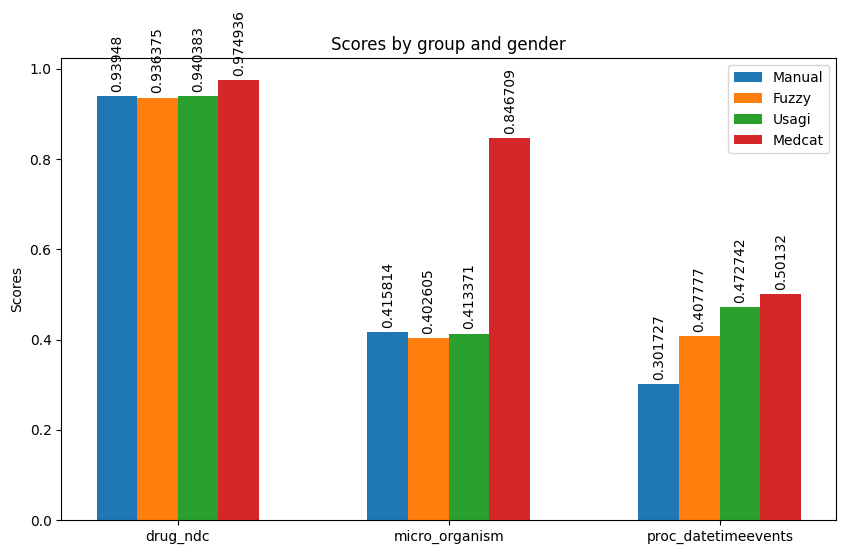

In [75]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 3*width/2, manualSemanticSimilarityScores, width, label='Manual')
rects2 = ax.bar(x - width/2, fuzzySemanticSimilarityScores, width, label='Fuzzy')
rects3 = ax.bar(x + width/2, usagiSemanticSimilarityScores, width, label='Usagi')
rects4 = ax.bar(x + 3*width/2, medcatSemanticSimilarityScores, width, label='Medcat')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, rotation=90)
ax.bar_label(rects2, padding=3, rotation=90)
ax.bar_label(rects3, padding=3, rotation=90)
ax.bar_label(rects4, padding=3, rotation=90)

# fig.tight_layout()
# plt.xticks(rotation=75, ha='right')
plt.show()